In [1]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt

symbol = 'SMH'
files = sorted(os.listdir(f'data/{symbol}'), key=lambda f: f'{f:>7}')


In [2]:
results = []
leverage = {}
for f in files:
    df = pd.read_csv(f'data/{symbol}/{f}')
    df.start_date = pd.to_datetime(df.start_date)
    df.end_date = pd.to_datetime(df.end_date)
    df['TTL'] = ((df.end_date - df.start_date).dt.days / 7).round(0)
    call_profits = df.call_end_price / df.call_start_price - 1
    mean_call_profit = call_profits.mean()
    annual_call_profit = (call_profits / df.TTL * 52).mean()
    positive_ratio = (call_profits > 0).mean()
    call_leverage = (df.call_strike_price / df.call_start_price).median()
    print(f'[{f:>7}] '
          f'mean profit: {mean_call_profit:+5.0%} '
        #   f'annual profit: {annual_call_profit:+6.0%} '
          f'positive: {positive_ratio:5.0%} '
          f'leverage: {call_leverage:4.1f} '
          f'daily tx: {df.call_median_volume.median():4.0f} '
          f'transactions: {len(df):3d} ')
    results.append({
        'profit': mean_call_profit,
        'positive': positive_ratio,
    })

    w = int(re.match(r'\d+', f)[0])
    leverage[w] = call_leverage        

[ 1w.csv] mean profit:  +30% positive:   38% leverage: 69.1 daily tx:   69 transactions: 103 
[ 2w.csv] mean profit:  +43% positive:   39% leverage: 44.9 daily tx:   25 transactions: 102 
[ 3w.csv] mean profit:  +53% positive:   41% leverage: 37.0 daily tx:   14 transactions:  99 
[ 4w.csv] mean profit:  +49% positive:   42% leverage: 30.3 daily tx:    9 transactions:  92 
[ 5w.csv] mean profit:  +69% positive:   49% leverage: 28.4 daily tx:    6 transactions:  90 
[ 6w.csv] mean profit:  +72% positive:   50% leverage: 26.3 daily tx:    5 transactions:  82 
[ 7w.csv] mean profit:  +98% positive:   53% leverage: 22.4 daily tx:    6 transactions:  51 
[ 8w.csv] mean profit:  +71% positive:   48% leverage: 21.7 daily tx:   20 transactions:  23 
[ 9w.csv] mean profit:  +89% positive:   55% leverage: 21.0 daily tx:   22 transactions:  22 
[10w.csv] mean profit:  +97% positive:   52% leverage: 19.5 daily tx:   16 transactions:  21 
[11w.csv] mean profit: +114% positive:   58% leverage: 18.4 

In [3]:
leverage

{1: 69.08212560386474,
 2: 44.9288840262582,
 3: 37.0216306156406,
 4: 30.34021816881259,
 5: 28.398378582202113,
 6: 26.281148429035753,
 7: 22.37654320987654,
 8: 21.67766258246937,
 9: 21.041970271058,
 10: 19.48051948051948,
 11: 18.42837273991655,
 12: 17.046004842615012,
 13: 16.018897996357012,
 14: 15.845070422535212,
 15: 14.603616133518775,
 16: 14.427480916030534,
 17: 14.47280134196022,
 18: 13.575425596824996,
 19: 13.333333333333334,
 20: 12.151898734177216,
 21: 12.605605100821354,
 22: 12.5,
 23: 11.560283687943263,
 24: 11.12759643916914,
 25: 11.412571627018579,
 26: 10.978520286396181}

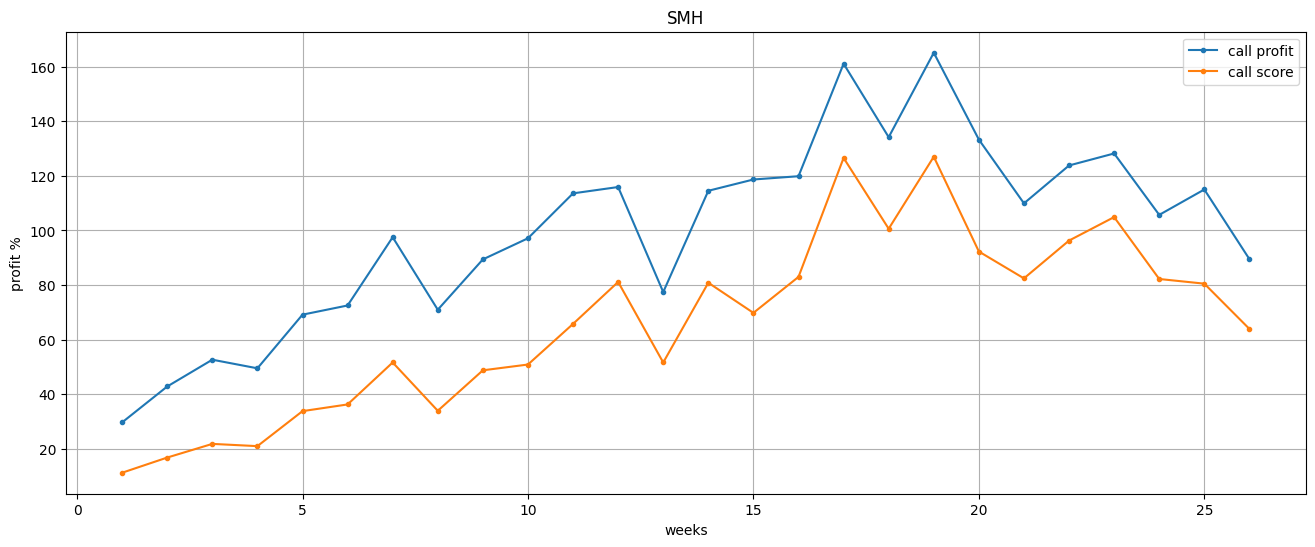

In [4]:
plt.figure(figsize=(16,6))
plt.plot([None]+[r['profit'] * 100 for r in results], label='call profit', marker='.')
plt.plot([None]+[r['profit'] * r['positive'] * 100 for r in results], label='call score', marker='.')
plt.legend(loc='best')
plt.title(symbol)
plt.xlabel('weeks')
plt.ylabel('profit %')
plt.grid()
plt.show()

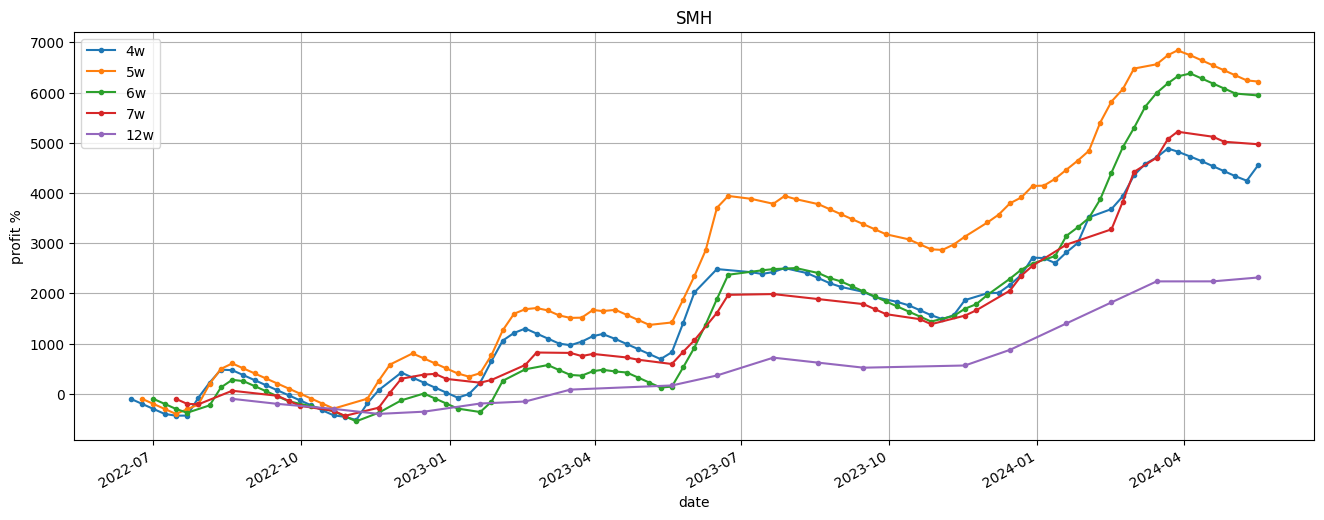

In [5]:
plt.figure(figsize=(16,6))

for n in [4,5,6,7,12]:
    k = f'{n}w'
    df = pd.read_csv(f'data/{symbol}/{k}.csv')
    df.end_date = pd.to_datetime(df.end_date)
    df = df.set_index('end_date')
    df[k] = (df.call_end_price / df.call_start_price - 1) * 100
    df[k].cumsum().plot(marker='.')

plt.legend(loc='best')
plt.title(symbol)
plt.xlabel('date')
plt.ylabel('profit %')
plt.grid()
plt.show()

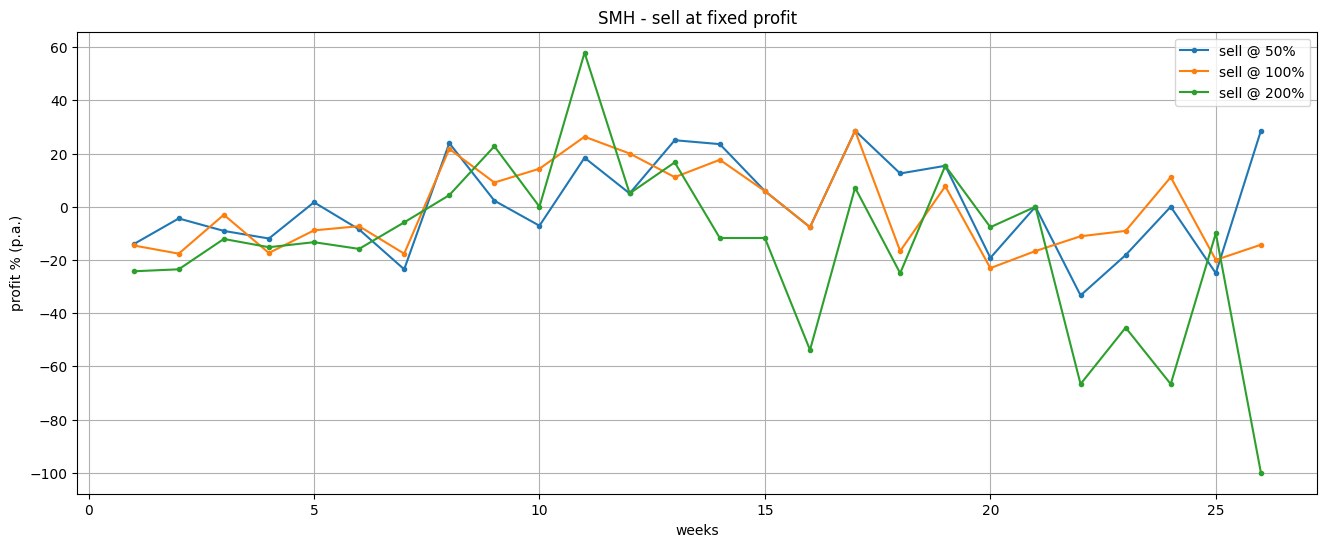

In [6]:
profit_thresholds = [0.5,1,2]
results = []
for f in files:
    df = pd.read_csv(f'data/{symbol}/{f}')
    df.start_date = pd.to_datetime(df.start_date)
    df.end_date = pd.to_datetime(df.end_date)
    df['TTL'] = ((df.end_date - df.start_date).dt.days / 7).round(0)
    call_max_profits = df.call_max_price / df.call_start_price - 1
    weeks = df.TTL.median()
    r = {}
    for p in profit_thresholds:
        q = (call_max_profits >= p).mean()
        r[p] = (q * (p + 1) - 1) #* 52 / weeks
    results.append(r)

plt.figure(figsize=(16,6))

for p in profit_thresholds:
    plt.plot([None]+[r[p] * 100 for r in results], label=f'sell @ {p:.0%}', marker='.')

plt.legend(loc='best')
plt.title(symbol + ' - sell at fixed profit')
plt.xlabel('weeks')
plt.ylabel('profit % (p.a.)')
plt.grid()
plt.show()

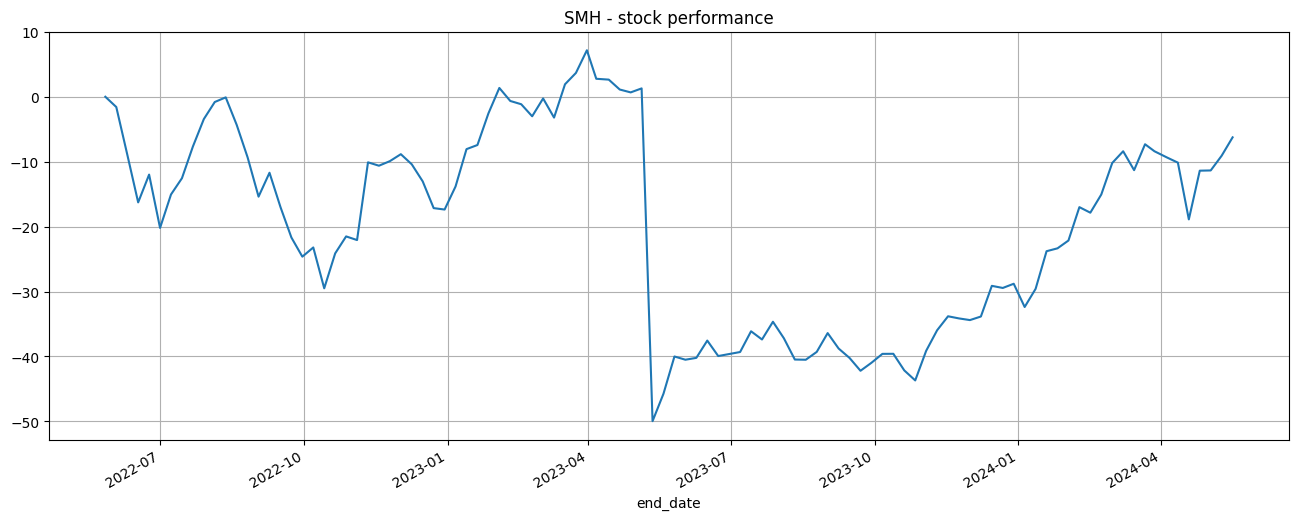

In [7]:
df = pd.read_csv(f'data/{symbol}/1w.csv')
df.end_date = pd.to_datetime(df.end_date)
df = df.set_index('end_date')

plt.figure(figsize=(16,6))
plt.title(symbol + ' - stock performance')
base = df.stock_end_price.iloc[0]
df['pct']=df.stock_end_price / base - 1
(df.pct * 100).plot()
plt.grid()

In [8]:
df = pd.read_csv(f'data/{symbol}/4w.csv')
df['call_profit'] = round((df.call_end_price / df.call_start_price - 1) * 100)
df['call_max_profit'] = round((df.call_max_price / df.call_start_price - 1) * 100)